In [1]:
import pandas as pd
import spacy, json
from sklearn import model_selection
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np


import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, models

In [2]:
df = pd.read_json(open("../../data/data.json", "r", encoding="utf8"))

with open('../../data/themes.json', 'r') as f:
    theme_codes = json.load(f)

In [3]:
themes_to_predict = ['arts & sciences', 'living', 'social commentaries', 
                     'relationships', 'love', 'nature', 'war', 'lgbtq', 'audio & music', 'public domain', 
                     'body', 'death', 'summer', 'religion', 'violence', 'eating']

In [4]:
texts_len = df['text'].apply(len)
df.drop(df[texts_len<50].index, inplace=True)

In [5]:
max_features = 10000  # maximum number of words in vocabulari 5000
max_len = 150  # max length of string

In [6]:
joined_text = df['title'] + df['text']
X = keras.preprocessing.sequence.pad_sequences(list(joined_text), maxlen=max_len, padding='post')

### Model 

In [7]:
embedding_dim = 128
model1 = keras.models.Sequential([
  keras.layers.Embedding(input_dim=max_features,
                           output_dim=embedding_dim,
                           input_length=max_len),
  keras.layers.Flatten(),
  keras.layers.Dense(2000,activation='relu'),
  keras.layers.Dense(500,activation='relu'),
  keras.layers.Dense(100,activation='relu'),
  keras.layers.Dense(1, activation='sigmoid')
])

model1.compile(optimizer='nadam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 150, 128)          1280000   
_________________________________________________________________
flatten (Flatten)            (None, 19200)             0         
_________________________________________________________________
dense (Dense)                (None, 2000)              38402000  
_________________________________________________________________
dense_1 (Dense)              (None, 500)               1000500   
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 40,732,701
Trainable params: 40,732,701
Non-trainable params: 0
____________________________________________

Theme #: arts & sciences
Epoch 1/5
367/367 [==============================] - 286s 780ms/step - loss: 0.4312 - binary_accuracy: 0.8471 - val_loss: 0.4517 - val_binary_accuracy: 0.8434
Epoch 2/5
367/367 [==============================] - 296s 806ms/step - loss: 0.1417 - binary_accuracy: 0.9466 - val_loss: 0.6484 - val_binary_accuracy: 0.8196
Epoch 3/5
367/367 [==============================] - 300s 817ms/step - loss: 0.0184 - binary_accuracy: 0.9969 - val_loss: 1.2588 - val_binary_accuracy: 0.8135
Epoch 4/5
367/367 [==============================] - 291s 793ms/step - loss: 0.0090 - binary_accuracy: 0.9975 - val_loss: 0.9610 - val_binary_accuracy: 0.8127
Epoch 5/5
41/41 [==============================] - 3s 68ms/step - loss: 1.3291 - binary_accuracy: 0.7951
Test Score Model1: 1.3291302919387817
Test Accuracy Model1: 0.7950882315635681


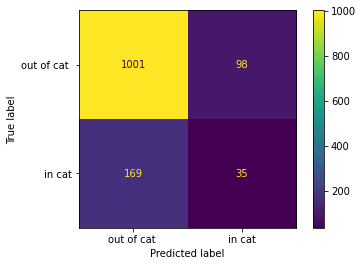

Theme #: living
Epoch 1/5
367/367 [==============================] - 283s 772ms/step - loss: 0.6681 - binary_accuracy: 0.6428 - val_loss: 0.6400 - val_binary_accuracy: 0.6523
Epoch 2/5
367/367 [==============================] - 248s 676ms/step - loss: 0.5009 - binary_accuracy: 0.7517 - val_loss: 0.6809 - val_binary_accuracy: 0.6124
Epoch 3/5
367/367 [==============================] - 161s 438ms/step - loss: 0.0503 - binary_accuracy: 0.9865 - val_loss: 1.3144 - val_binary_accuracy: 0.5710
Epoch 4/5
367/367 [==============================] - 159s 435ms/step - loss: 0.0094 - binary_accuracy: 0.9979 - val_loss: 1.8883 - val_binary_accuracy: 0.5994
Epoch 5/5
41/41 [==============================] - 1s 24ms/step - loss: 2.2612 - binary_accuracy: 0.6063
Test Score Model1: 2.261201858520508
Test Accuracy Model1: 0.6062931418418884


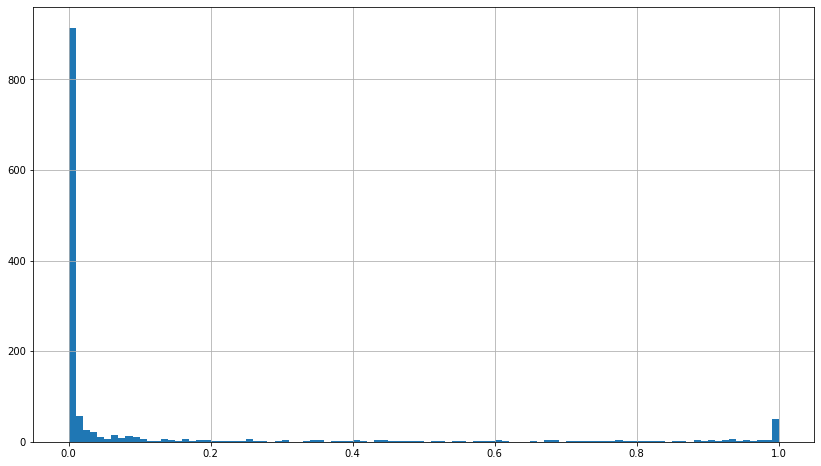

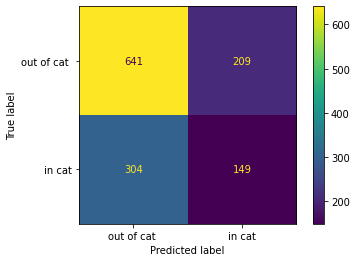

Theme #: social commentaries
Epoch 1/5
367/367 [==============================] - 157s 427ms/step - loss: 0.5501 - binary_accuracy: 0.7640 - val_loss: 0.5288 - val_binary_accuracy: 0.7667
Epoch 2/5
367/367 [==============================] - 157s 428ms/step - loss: 0.3142 - binary_accuracy: 0.8584 - val_loss: 0.6343 - val_binary_accuracy: 0.7398
Epoch 3/5
367/367 [==============================] - 157s 428ms/step - loss: 0.0320 - binary_accuracy: 0.9895 - val_loss: 0.9761 - val_binary_accuracy: 0.7229
Epoch 4/5
367/367 [==============================] - 157s 428ms/step - loss: 0.0100 - binary_accuracy: 0.9983 - val_loss: 1.8349 - val_binary_accuracy: 0.7260
Epoch 5/5
41/41 [==============================] - 1s 24ms/step - loss: 1.8469 - binary_accuracy: 0.7191
Test Score Model1: 1.8468608856201172
Test Accuracy Model1: 0.7191097736358643


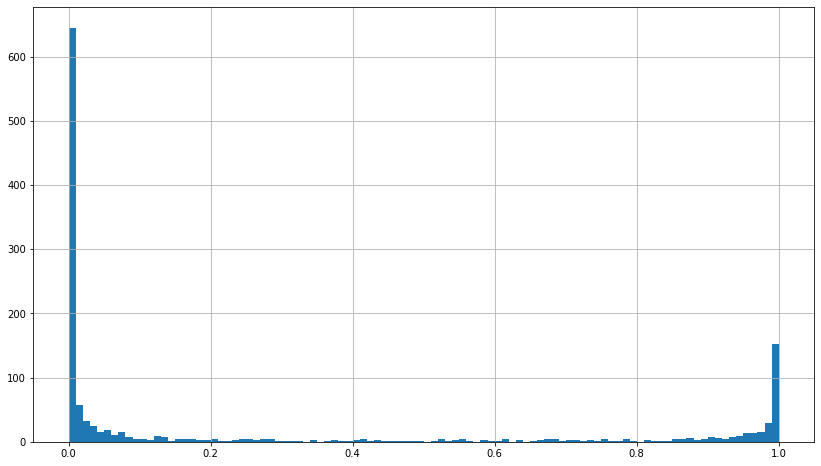

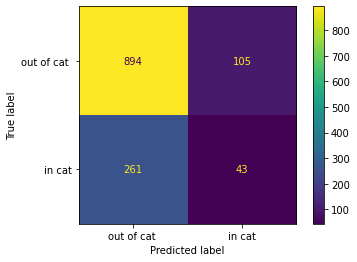

Theme #: relationships
Epoch 1/5
367/367 [==============================] - 157s 427ms/step - loss: 0.5013 - binary_accuracy: 0.7935 - val_loss: 0.5166 - val_binary_accuracy: 0.7989
Epoch 2/5
367/367 [==============================] - 157s 427ms/step - loss: 0.2410 - binary_accuracy: 0.8873 - val_loss: 0.6111 - val_binary_accuracy: 0.7467
Epoch 3/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0236 - binary_accuracy: 0.9930 - val_loss: 1.0411 - val_binary_accuracy: 0.7529
Epoch 4/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0043 - binary_accuracy: 0.9991 - val_loss: 1.3241 - val_binary_accuracy: 0.7567
Epoch 5/5
41/41 [==============================] - 1s 24ms/step - loss: 1.6148 - binary_accuracy: 0.7513
Test Score Model1: 1.6147528886795044
Test Accuracy Model1: 0.7513430714607239


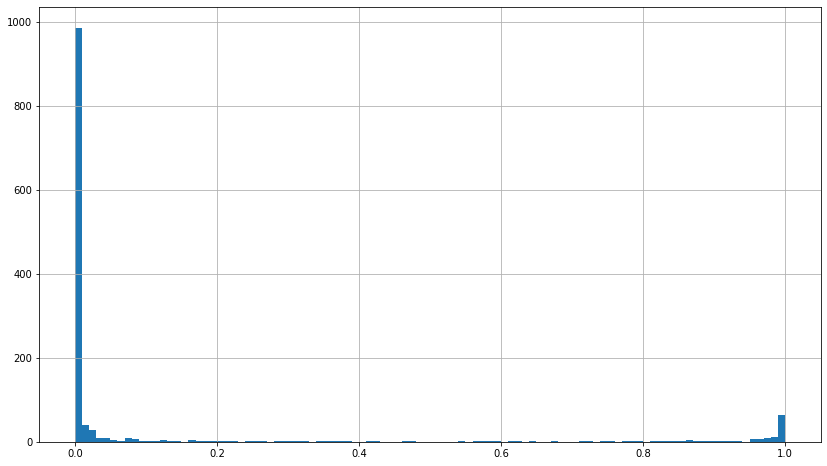

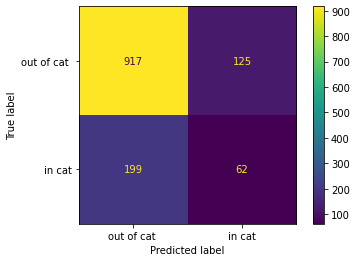

Theme #: love
Epoch 1/5
367/367 [==============================] - 157s 428ms/step - loss: 0.3773 - binary_accuracy: 0.8707 - val_loss: 0.3657 - val_binary_accuracy: 0.8665
Epoch 2/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0914 - binary_accuracy: 0.9654 - val_loss: 0.5833 - val_binary_accuracy: 0.7982
Epoch 3/5
367/367 [==============================] - 160s 437ms/step - loss: 0.0104 - binary_accuracy: 0.9972 - val_loss: 1.0869 - val_binary_accuracy: 0.8550
Epoch 4/5
367/367 [==============================] - 157s 428ms/step - loss: 0.0028 - binary_accuracy: 0.9994 - val_loss: 0.9579 - val_binary_accuracy: 0.8473
Epoch 5/5
41/41 [==============================] - 1s 25ms/step - loss: 1.1386 - binary_accuracy: 0.8434
Test Score Model1: 1.1385644674301147
Test Accuracy Model1: 0.8434382081031799


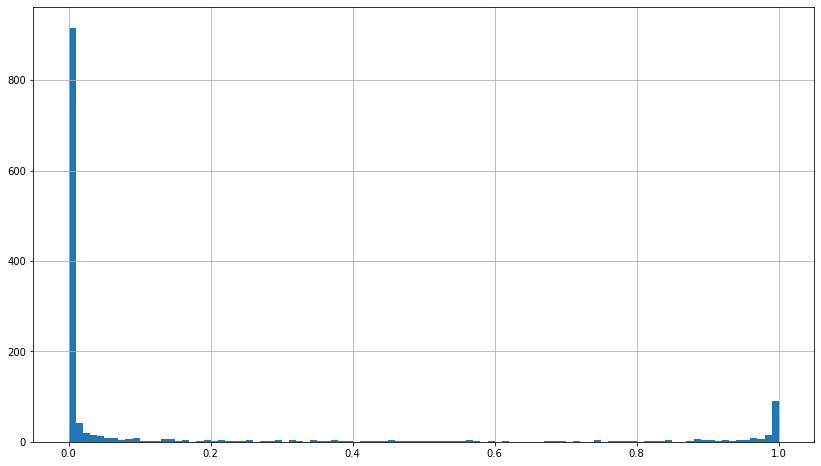

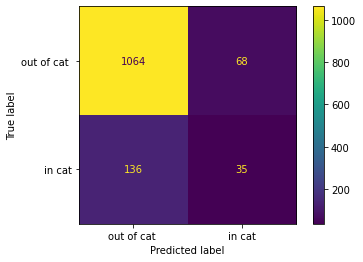

Theme #: nature
Epoch 1/5
367/367 [==============================] - 157s 428ms/step - loss: 0.5057 - binary_accuracy: 0.7914 - val_loss: 0.4489 - val_binary_accuracy: 0.7997
Epoch 2/5
367/367 [==============================] - 157s 428ms/step - loss: 0.1820 - binary_accuracy: 0.9277 - val_loss: 0.6211 - val_binary_accuracy: 0.7698
Epoch 3/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0257 - binary_accuracy: 0.9925 - val_loss: 0.9031 - val_binary_accuracy: 0.7567
Epoch 4/5
367/367 [==============================] - 157s 429ms/step - loss: 0.0027 - binary_accuracy: 0.9992 - val_loss: 1.1881 - val_binary_accuracy: 0.7682
Epoch 5/5
41/41 [==============================] - 1s 25ms/step - loss: 1.0728 - binary_accuracy: 0.7483
Test Score Model1: 1.0728213787078857
Test Accuracy Model1: 0.7482731938362122


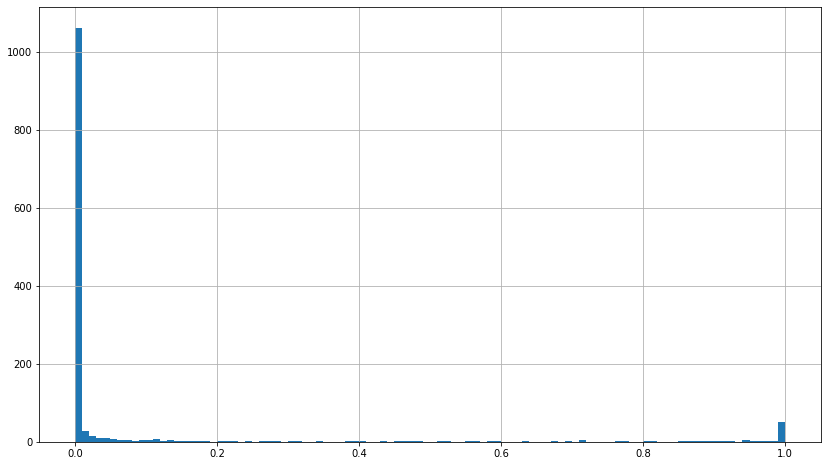

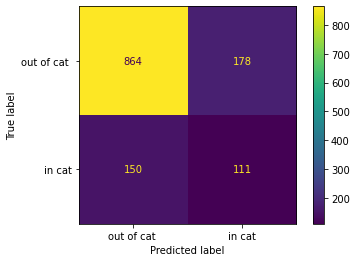

Theme #: war
Epoch 1/5
367/367 [==============================] - 157s 426ms/step - loss: 0.2460 - binary_accuracy: 0.9216 - val_loss: 0.2312 - val_binary_accuracy: 0.9371
Epoch 2/5
367/367 [==============================] - 156s 426ms/step - loss: 0.0443 - binary_accuracy: 0.9848 - val_loss: 0.4582 - val_binary_accuracy: 0.9355
Epoch 3/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0042 - binary_accuracy: 0.9992 - val_loss: 0.5875 - val_binary_accuracy: 0.9340
Epoch 4/5
367/367 [==============================] - 157s 428ms/step - loss: 7.6197e-04 - binary_accuracy: 0.9997 - val_loss: 0.7051 - val_binary_accuracy: 0.9355
Epoch 5/5
41/41 [==============================] - 1s 24ms/step - loss: 0.7605 - binary_accuracy: 0.9371
Test Score Model1: 0.7604736089706421
Test Accuracy Model1: 0.9370682835578918


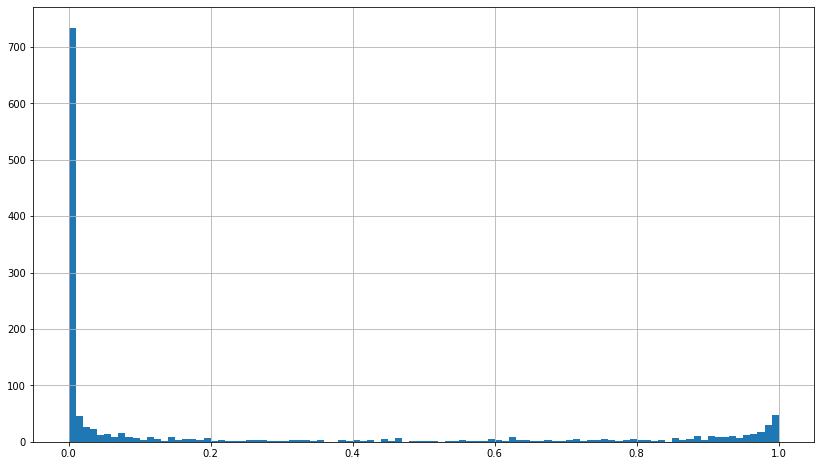

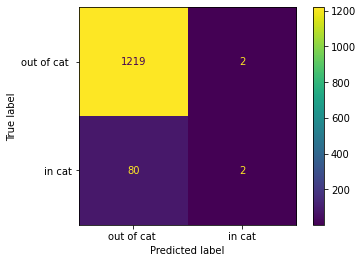

Theme #: lgbtq
Epoch 1/5
367/367 [==============================] - 157s 427ms/step - loss: 0.2312 - binary_accuracy: 0.9385 - val_loss: 0.2338 - val_binary_accuracy: 0.9340
Epoch 2/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0527 - binary_accuracy: 0.9783 - val_loss: 0.3548 - val_binary_accuracy: 0.9233
Epoch 3/5
367/367 [==============================] - 157s 429ms/step - loss: 0.0028 - binary_accuracy: 0.9993 - val_loss: 0.8271 - val_binary_accuracy: 0.9302
Epoch 4/5
367/367 [==============================] - 157s 428ms/step - loss: 2.4157e-04 - binary_accuracy: 0.9999 - val_loss: 0.8287 - val_binary_accuracy: 0.9279
Epoch 5/5
41/41 [==============================] - 1s 24ms/step - loss: 0.8589 - binary_accuracy: 0.9279
Test Score Model1: 0.8589291572570801
Test Accuracy Model1: 0.9278587698936462


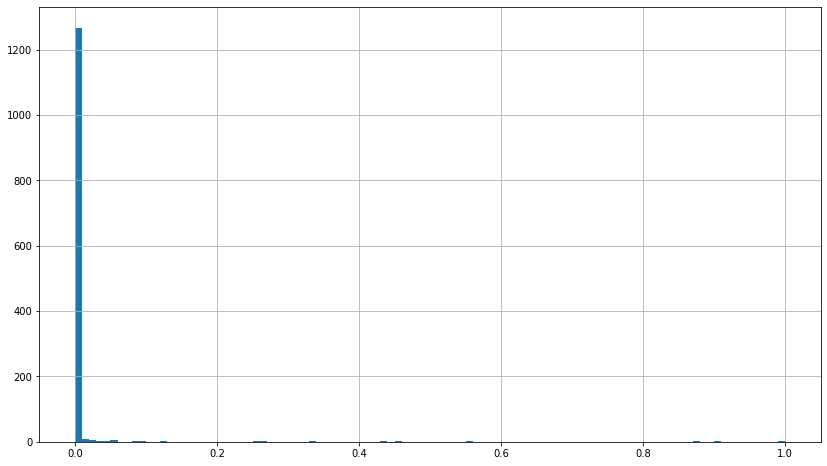

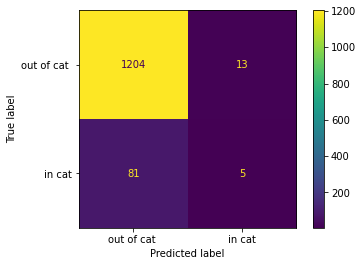

Theme #: audio & music
Epoch 1/5
367/367 [==============================] - 157s 427ms/step - loss: 0.3569 - binary_accuracy: 0.8896 - val_loss: 0.3462 - val_binary_accuracy: 0.8956
Epoch 2/5
367/367 [==============================] - 157s 427ms/step - loss: 0.1154 - binary_accuracy: 0.9531 - val_loss: 0.5884 - val_binary_accuracy: 0.8741
Epoch 3/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0617 - binary_accuracy: 0.9950 - val_loss: 1.1453 - val_binary_accuracy: 0.8749
Epoch 4/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0462 - binary_accuracy: 0.9974 - val_loss: 1.2174 - val_binary_accuracy: 0.8388
Epoch 5/5
41/41 [==============================] - 1s 24ms/step - loss: 1.6308 - binary_accuracy: 0.8611
Test Score Model1: 1.63075590133667
Test Accuracy Model1: 0.8610897660255432


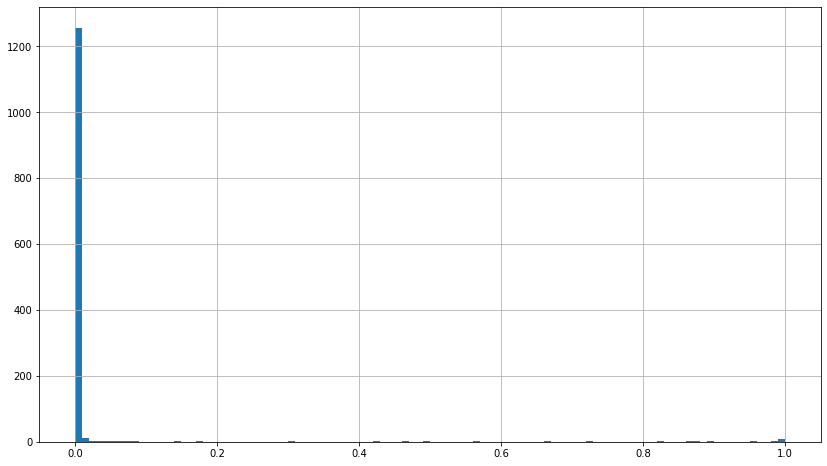

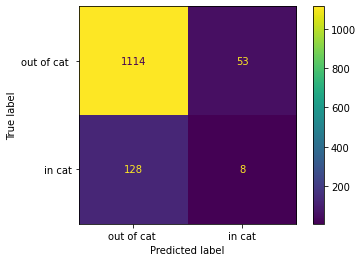

Theme #: public domain
Epoch 1/5
367/367 [==============================] - 157s 427ms/step - loss: 0.1719 - binary_accuracy: 0.9540 - val_loss: 0.1503 - val_binary_accuracy: 0.9593
Epoch 2/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0337 - binary_accuracy: 0.9919 - val_loss: 0.1557 - val_binary_accuracy: 0.9555
Epoch 3/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0137 - binary_accuracy: 0.9988 - val_loss: 0.4055 - val_binary_accuracy: 0.9524
Epoch 4/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0058 - binary_accuracy: 0.9988 - val_loss: 0.2327 - val_binary_accuracy: 0.9394
Epoch 5/5
41/41 [==============================] - 1s 24ms/step - loss: 0.3193 - binary_accuracy: 0.9547
Test Score Model1: 0.3193342685699463
Test Accuracy Model1: 0.9547199010848999


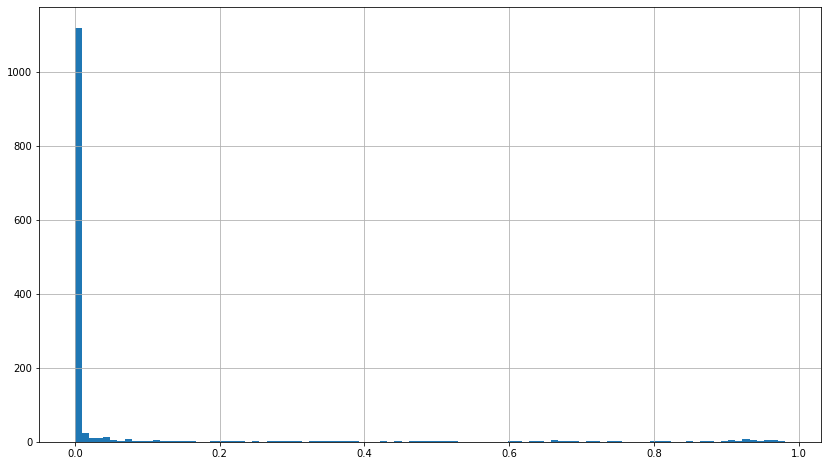

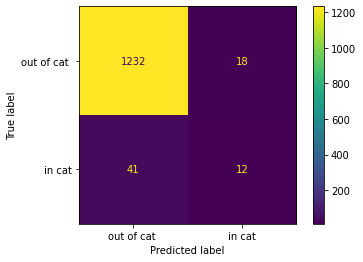

Theme #: body
Epoch 1/5
367/367 [==============================] - 157s 428ms/step - loss: 0.3687 - binary_accuracy: 0.8814 - val_loss: 0.3209 - val_binary_accuracy: 0.9064
Epoch 2/5
367/367 [==============================] - 156s 426ms/step - loss: 0.1084 - binary_accuracy: 0.9587 - val_loss: 0.4084 - val_binary_accuracy: 0.8573
Epoch 3/5
367/367 [==============================] - 156s 426ms/step - loss: 0.0100 - binary_accuracy: 0.9989 - val_loss: 0.7509 - val_binary_accuracy: 0.8872
Epoch 4/5
367/367 [==============================] - 157s 427ms/step - loss: 8.2720e-05 - binary_accuracy: 1.0000 - val_loss: 1.2464 - val_binary_accuracy: 0.8864
Epoch 5/5
41/41 [==============================] - 1s 25ms/step - loss: 1.3908 - binary_accuracy: 0.8810
Test Score Model1: 1.3908357620239258
Test Accuracy Model1: 0.8810437321662903


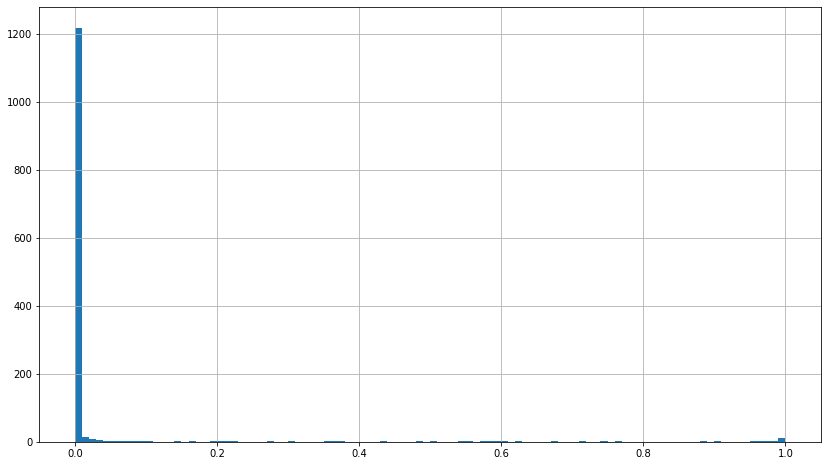

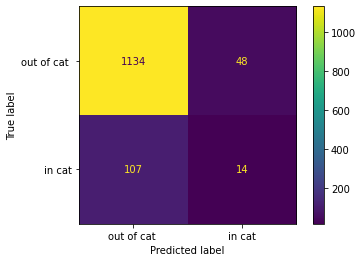

Theme #: death
Epoch 1/5
367/367 [==============================] - 156s 426ms/step - loss: 0.3851 - binary_accuracy: 0.8767 - val_loss: 0.3519 - val_binary_accuracy: 0.8918
Epoch 2/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0815 - binary_accuracy: 0.9762 - val_loss: 0.5128 - val_binary_accuracy: 0.8734
Epoch 3/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0301 - binary_accuracy: 0.9984 - val_loss: 0.7407 - val_binary_accuracy: 0.8772
Epoch 4/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0189 - binary_accuracy: 0.9988 - val_loss: 0.9692 - val_binary_accuracy: 0.8480
Epoch 5/5
41/41 [==============================] - 1s 24ms/step - loss: 1.1072 - binary_accuracy: 0.8511
Test Score Model1: 1.1072312593460083
Test Accuracy Model1: 0.8511128425598145


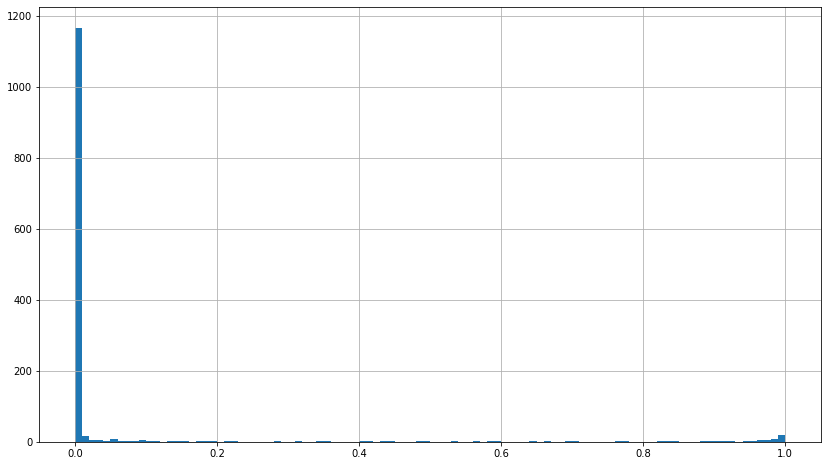

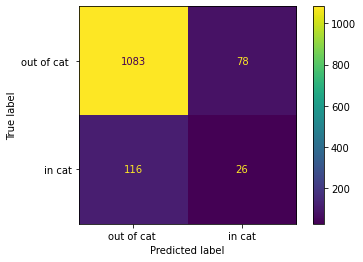

Theme #: summer
Epoch 1/5
367/367 [==============================] - 156s 426ms/step - loss: 0.1207 - binary_accuracy: 0.9746 - val_loss: 0.1272 - val_binary_accuracy: 0.9777
Epoch 2/5
367/367 [==============================] - 157s 429ms/step - loss: 0.0155 - binary_accuracy: 0.9971 - val_loss: 0.2749 - val_binary_accuracy: 0.9785
Epoch 3/5
367/367 [==============================] - 157s 429ms/step - loss: 0.0044 - binary_accuracy: 0.9996 - val_loss: 0.3556 - val_binary_accuracy: 0.9793
Epoch 4/5
367/367 [==============================] - 157s 428ms/step - loss: 0.0038 - binary_accuracy: 0.9998 - val_loss: 0.3764 - val_binary_accuracy: 0.9777
Epoch 5/5
41/41 [==============================] - 1s 25ms/step - loss: 0.3854 - binary_accuracy: 0.9777
Test Score Model1: 0.38536784052848816
Test Accuracy Model1: 0.9777436852455139


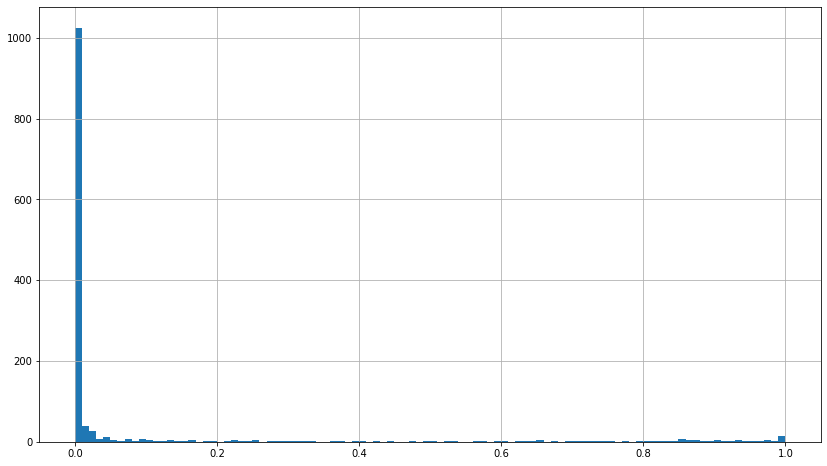

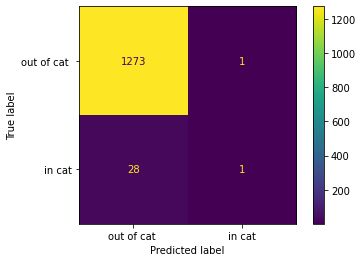

Theme #: religion
Epoch 1/5
367/367 [==============================] - 157s 428ms/step - loss: 0.3240 - binary_accuracy: 0.9069 - val_loss: 0.2439 - val_binary_accuracy: 0.9294
Epoch 2/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0630 - binary_accuracy: 0.9786 - val_loss: 0.4034 - val_binary_accuracy: 0.9133
Epoch 3/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0178 - binary_accuracy: 0.9986 - val_loss: 0.4779 - val_binary_accuracy: 0.9102
Epoch 4/5
367/367 [==============================] - 157s 428ms/step - loss: 0.0141 - binary_accuracy: 0.9993 - val_loss: 0.5491 - val_binary_accuracy: 0.9202
Epoch 5/5
41/41 [==============================] - 1s 25ms/step - loss: 0.5500 - binary_accuracy: 0.9171
Test Score Model1: 0.5499976873397827
Test Accuracy Model1: 0.9171143770217896


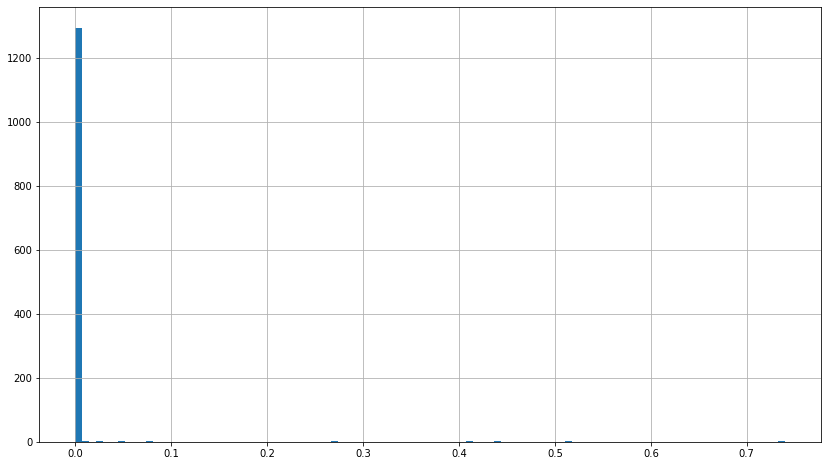

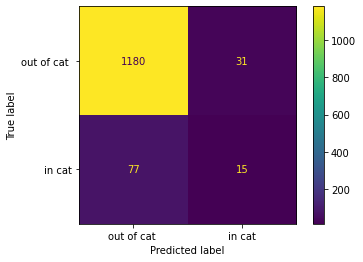

Theme #: violence
Epoch 1/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0907 - binary_accuracy: 0.9759 - val_loss: 0.0532 - val_binary_accuracy: 0.9939
Epoch 2/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0044 - binary_accuracy: 0.9989 - val_loss: 0.0795 - val_binary_accuracy: 0.9939
Epoch 3/5
367/367 [==============================] - 157s 428ms/step - loss: 0.0017 - binary_accuracy: 0.9997 - val_loss: 0.0832 - val_binary_accuracy: 0.9939
Epoch 4/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0015 - binary_accuracy: 0.9998 - val_loss: 0.0998 - val_binary_accuracy: 0.9939
Epoch 5/5
41/41 [==============================] - 1s 24ms/step - loss: 0.1018 - binary_accuracy: 0.9939
Test Score Model1: 0.10180627554655075
Test Accuracy Model1: 0.9938603043556213


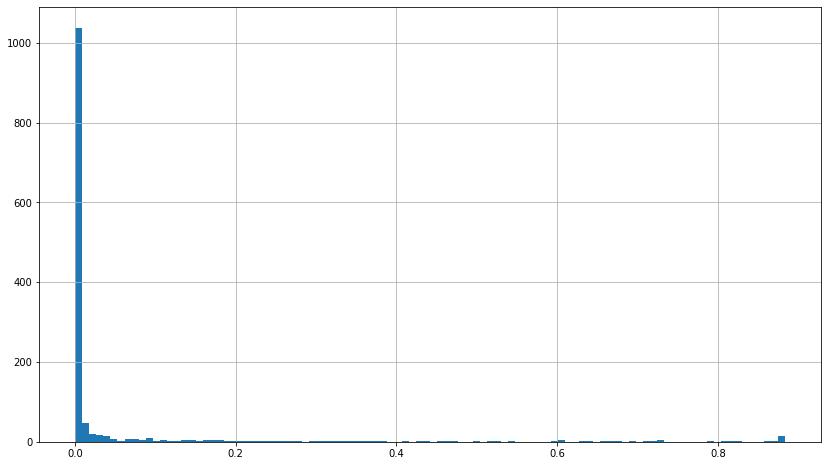

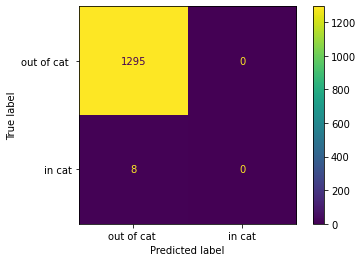

Theme #: eating
Epoch 1/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0547 - binary_accuracy: 0.9893 - val_loss: 0.0355 - val_binary_accuracy: 0.9954
Epoch 2/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0085 - binary_accuracy: 0.9978 - val_loss: 0.0548 - val_binary_accuracy: 0.9954
Epoch 3/5
367/367 [==============================] - 157s 427ms/step - loss: 0.0011 - binary_accuracy: 0.9999 - val_loss: 0.2079 - val_binary_accuracy: 0.9954
Epoch 4/5
367/367 [==============================] - 156s 426ms/step - loss: 9.4974e-04 - binary_accuracy: 1.0000 - val_loss: 0.2318 - val_binary_accuracy: 0.9954
Epoch 5/5
41/41 [==============================] - 1s 25ms/step - loss: 0.2374 - binary_accuracy: 0.9954
Test Score Model1: 0.23744380474090576
Test Accuracy Model1: 0.9953952431678772


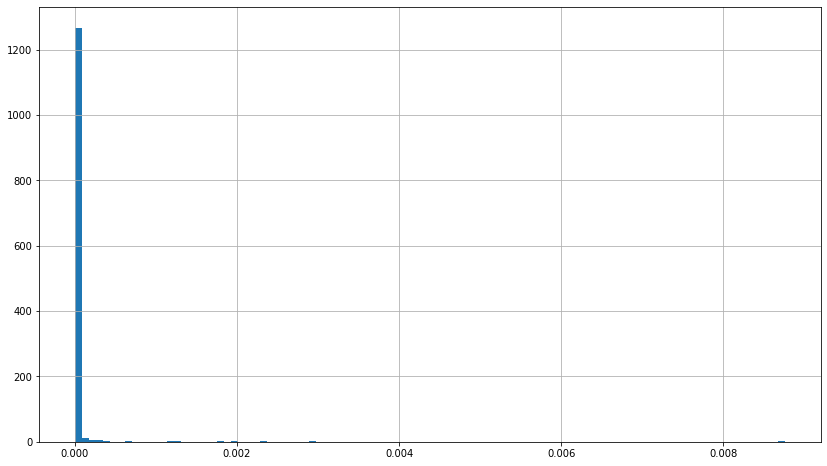

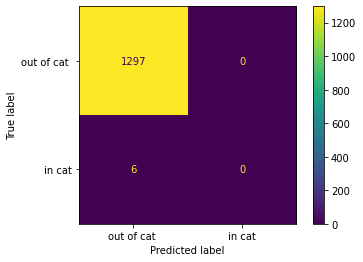

{'arts & sciences': 0.7950882315635681, 'living': 0.6062931418418884, 'social commentaries': 0.7191097736358643, 'relationships': 0.7513430714607239, 'love': 0.8434382081031799, 'nature': 0.7482731938362122, 'war': 0.9370682835578918, 'lgbtq': 0.9278587698936462, 'audio & music': 0.8610897660255432, 'public domain': 0.9547199010848999, 'body': 0.8810437321662903, 'death': 0.8511128425598145, 'summer': 0.9777436852455139, 'religion': 0.9171143770217896, 'violence': 0.9938603043556213, 'eating': 0.9953952431678772}


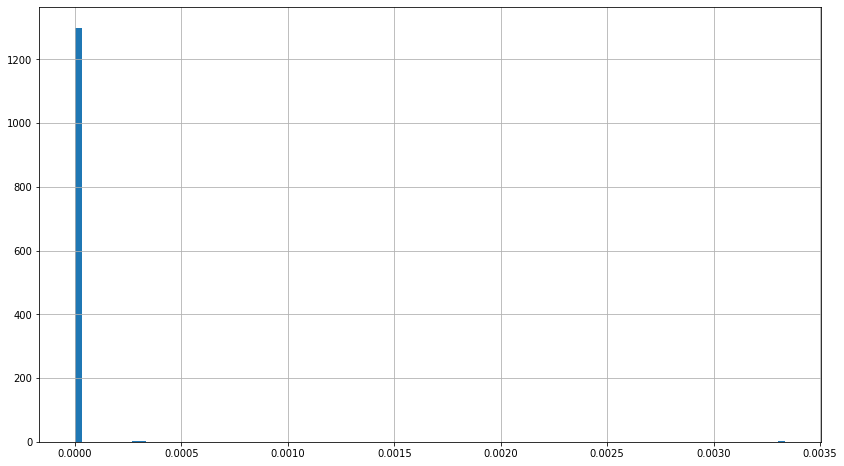

In [8]:
epochs = 5
result = {}
preds = {}

for theme in themes_to_predict:
    print('Theme #:', theme)
    theme_index = theme_codes[theme]
    Y = np.array([row['themes'][theme_index] for index, row in df.iterrows()])
    X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, test_size=0.1, random_state=42)
   
    model1.fit(np.array(X_train), np.array(Y_train),
          #batch_size=128,
          validation_data=(np.array(X_test),np.array(Y_test)),
          epochs=epochs)
    score = model1.evaluate(np.array(X_test), np.array(Y_test)) 
    print("Test Score Model1:", score[0])
    print("Test Accuracy Model1:", score[1])
    y_pred = model1.predict(X_test)
    class_names = ['out of cat ', 'in cat']
    cm = confusion_matrix(Y_test, np.rint(y_pred))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot()
    plt.show()
    pd.Series(y_pred.flatten()).hist(bins=100, figsize=(14, 8)).figure
    preds[theme] = y_pred
    result[theme] = score[1]
print(result)

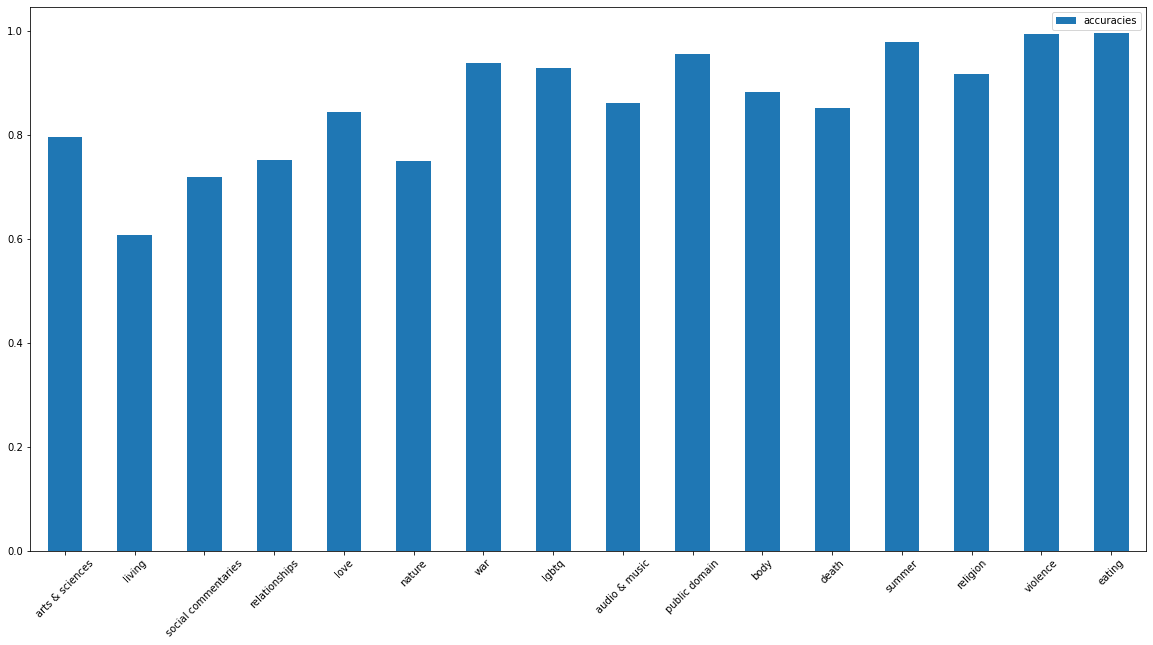

In [9]:
dfc = pd.DataFrame({'accuracies': result.values()}, index=result.keys())
ax = dfc.plot.bar(rot=45, figsize=(20, 10))